In [ ]:
from PIL import Image
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import os
import cv2
from sklearn.utils import shuffle
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras import layers
from keras.models import Model
from keras.layers import Input
from keras.layers import Dense
from keras.preprocessing import image
from tensorflow.python.ops.numpy_ops import np_config
import tensorflow_datasets as tfds
from sklearn.model_selection import train_test_split
from tflite_model_maker import model_spec
from tflite_model_maker import image_classifier
from tflite_model_maker.image_classifier import DataLoader
from tensorflow.keras.applications import MobileNetV3Small

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
IMG_SIZE = 224
NUM_CLASSES= 14
IMAGE_SHAPE = [224,224]
imageMean: 127.5
imageStd: 127.5

In [ ]:
def load_images_from_folder(folder,i): #Couldn't use common image loaders due to diversity of extensions
    image = []
    image_y= []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        if img is not None:
            img = cv2.resize(img,(IMG_SIZE,IMG_SIZE))
            img = img.reshape(IMG_SIZE,IMG_SIZE,3)
            image.append(img)
            image_y.append(i)
    return image,image_y

In [ ]:
labels = ["basking", "blacktip", "blue", "bull", "hammerhead", "lemon","mako", "nurse", "sandtiger", "thresher","tiger", "whale", "white", "whitetip"]
X = np.empty((0,IMG_SIZE,IMG_SIZE,3))
y = np.empty((0,1))
for i in range(len(labels)):
    images, images_y = load_images_from_folder(r"/content/drive/MyDrive/sharks/"+labels[i],i)
    X = np.append(X,images,0)
    y = np.append(y,images_y)

In [ ]:
for i in range(len(X)): #Numpy arrays converted back to files to save in DataLoader as JPEG
    im = Image.fromarray(X[i].astype("uint8"))
    im.save(f'/content/drive/MyDrive/sharks_final/{labels[int(y[i])]}/{i}.png', "JPEG")

In [ ]:
BATCH_SIZE = 16
BUFFER_SIZE = 1000
img_height = 224
img_width = 224
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/drive/MyDrive/sharks_final",
    validation_split = 0.2,
    subset = "training",
    label_mode = 'int',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE
)

Found 1553 files belonging to 14 classes.
Using 1243 files for training.


In [ ]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  "/content/drive/MyDrive/sharks_final",
   validation_split = 0.2,
    subset = "validation",
    label_mode = 'int',
  seed=123,
  image_size=(img_height, img_width),
  batch_size=BATCH_SIZE
)

Found 1553 files belonging to 14 classes.
Using 310 files for validation.


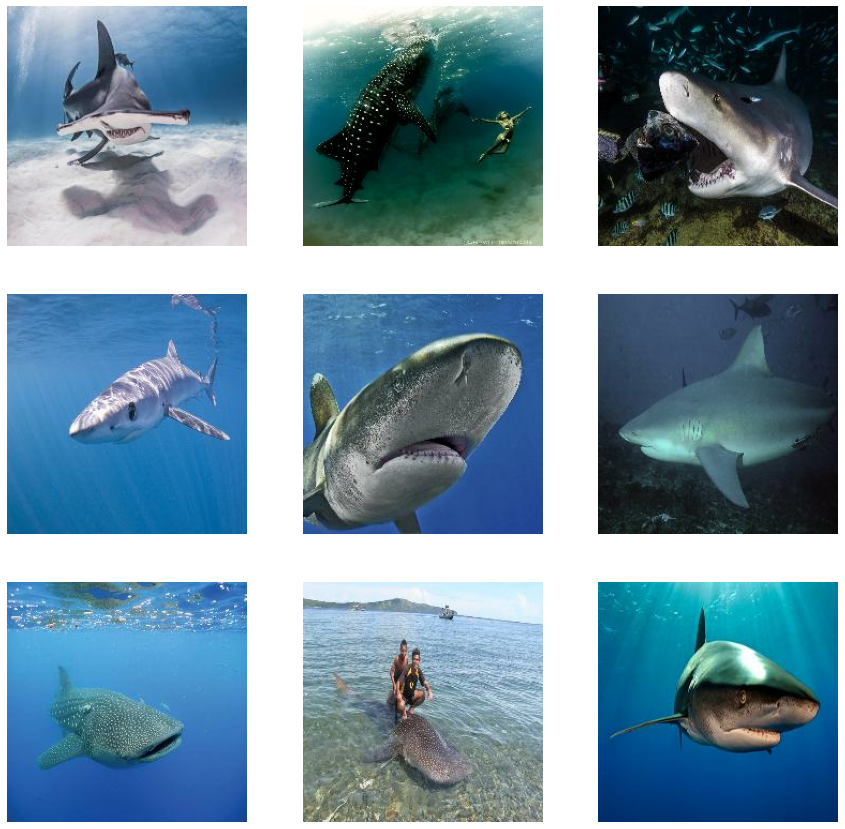

In [ ]:
plt.figure(figsize=(15, 15))
for i in range(9):
  ax = plt.subplot(3, 3, i+1)
  for (image, label) in tfds.as_numpy(train_ds.take(1)):
    plt.imshow(image[0].astype('uint8'))
    plt.axis("off")

In [ ]:
def create_model():
    model = tf.keras.applications.MobileNetV3Small(input_shape=(IMG_SIZE, IMG_SIZE, 3), weights='imagenet', include_top=False, include_preprocessing= True)
    # Freeze Layers
    for layer in model.layers:
        layer.trainable = False

    # add trainable layers
    x = tf.keras.layers.GlobalAveragePooling2D()(model.output)
    x = tf.keras.layers.Flatten()(x)
    x = tf.keras.layers.Dense(512, activation='relu')(x)
    predicition = tf.keras.layers.Dense(NUM_CLASSES, activation='softmax')(x)

    # final model
    model = tf.keras.models.Model(inputs=model.input, outputs=predicition)

    # Compile the model
    optimizer=tf.keras.optimizers.SGD()
    model.compile(loss='sparse_categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

    return model

In [ ]:
model = create_model()

6709248/6698480 [==============================] - 0s 0us/step


In [ ]:
model.summary()

In [ ]:
def lr_schedule(epoch): #Returns a custom learning rate that decreases as epochs progress.
    learning_rate = 0.2
    if epoch > 5:
        learning_rate = 0.02
    if epoch > 10:
        learning_rate = 0.01
    if epoch > 15:
        learning_rate = 0.005
    tf.summary.scalar('learning rate', data=learning_rate, step=epoch)
    return learning_rate

# Learning Rate Scheduler Callback
lr_callback = tf.keras.callbacks.LearningRateScheduler(lr_schedule)

# Early Stopping Callback
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

# Save model checkpoint
checkpoint_path = "model_checkpoints/model.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)

# Create a callback that saves the model's weights
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 monitor='val_loss',
                                                 save_weights_only=True,
                                                 save_best_only=True,
                                                 verbose=1)

# Train Model
with tf.device('/device:GPU:0'):
  history = model.fit(
      train_ds.repeat(),
      epochs = 50,
      steps_per_epoch = 1240 // BATCH_SIZE,
      validation_data=val_ds.repeat(),
      validation_steps = 309 // BATCH_SIZE,
      callbacks=[early_stopping, lr_callback, cp_callback]
  )

Epoch 1/50
77/77 [==============================] - 157s 2s/step - loss: 1.6360 - accuracy: 0.4765 - val_loss: 1.2590 - val_accuracy: 0.5757

Epoch 00001: val_loss improved from inf to 1.25902, saving model to model_checkpoints/model.ckpt
Epoch 2/50
77/77 [==============================] - 5s 56ms/step - loss: 0.7286 - accuracy: 0.7661 - val_loss: 1.1468 - val_accuracy: 0.6250

Epoch 00002: val_loss improved from 1.25902 to 1.14683, saving model to model_checkpoints/model.ckpt
Epoch 3/50
77/77 [==============================] - 4s 54ms/step - loss: 0.3726 - accuracy: 0.8973 - val_loss: 1.1315 - val_accuracy: 0.6776

Epoch 00003: val_loss improved from 1.14683 to 1.13152, saving model to model_checkpoints/model.ckpt
Epoch 4/50
77/77 [==============================] - 4s 56ms/step - loss: 0.2041 - accuracy: 0.9503 - val_loss: 1.0625 - val_accuracy: 0.6743

Epoch 00004: val_loss improved from 1.13152 to 1.06245, saving model to model_checkpoints/model.ckpt
Epoch 5/50
77/77 [==============

In [ ]:
from sklearn.metrics import accuracy_score
image_batch, label_batch = val_ds.as_numpy_iterator().next()
predictions = model.predict_on_batch(image_batch)

prediction_classes = np.argmax(predictions, axis=1)
acc = accuracy_score(prediction_classes, label_batch)
acc

0.6875

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


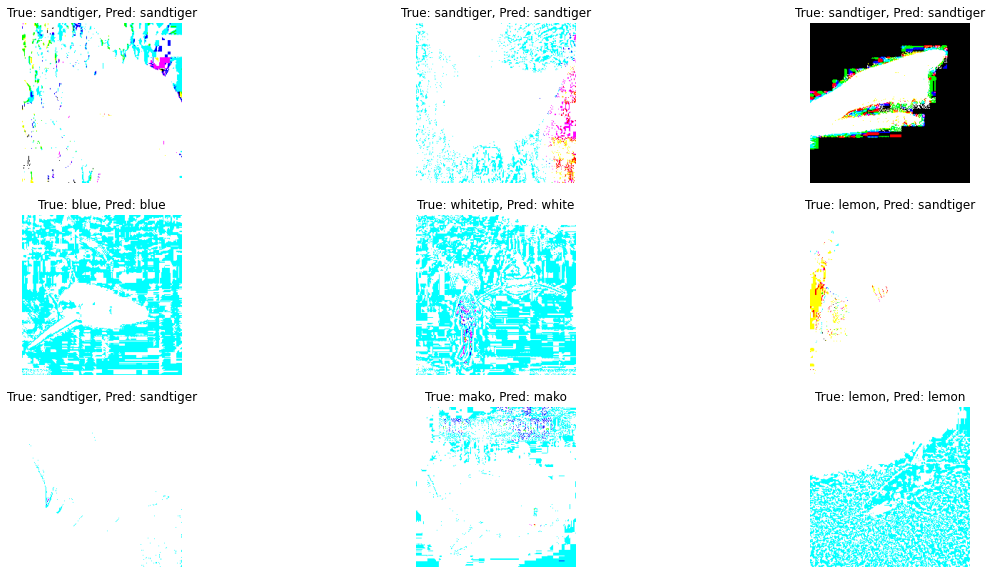

In [ ]:
labels = ["basking", "blacktip", "blue", "bull", "hammerhead", "lemon","mako", "nurse", "sandtiger", "thresher","tiger", "whale", "white", "whitetip"]
plt.figure(figsize=(20, 10))
for i in range(9):
  msg = "True: " + str(labels[label_batch[i]]) + ", " + "Pred: " + str(labels[np.argmax(predictions[i])])
  ax = plt.subplot(3, 3, i + 1)
  plt.imshow(image_batch[i])
  plt.title(msg)
  plt.axis("off")

In [ ]:
import tempfile
tmpdir = tempfile.mkdtemp()
mobilenet_save_path = os.path.join(tmpdir, "mobilenet_v2/")
tf.saved_model.save(model, mobilenet_save_path)

INFO:tensorflow:Assets written to: C:\Users\ayn_2\AppData\Local\Temp\tmphr8nssig\mobilenet_v2/assets


In [ ]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Save the model.
with open('model_fp16.tflite', 'wb') as f:
  f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Users\ayn_2\AppData\Local\Temp\tmpp7t2ifmo\assets


C:\Users\ayn_2\anaconda3\lib\site-packages\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '
